Date       0
Unit       0
Minimum    0
Maximum    0
Average    0
Market     0
dtype: int64


C:\Users\nh013\AppData\Local\Temp\ipykernel_3608\2003391800.py:53: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean=df.mean()
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nh013\anaconda3\lib\site-packages\sklea

Epoch 1/100
67/67 [==============================] - 1s 2ms/step - loss: 0.1813
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 6.0696e-04
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 2.9688e-04
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 1.9071e-04
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 1.4334e-04
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 1.0365e-04
Epoch 8/100
67/67 [==============================] - 0s 2ms/step - loss: 7.9988e-05
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 6.5458e-05
Epoch 10/100
67/67 [==============================] - 0s 2ms/step - loss: 5.6756e-05
Epoch 11/100
67/67 [==============================] - 0s 2ms/step - loss: 4.8858e-05
Epoch 12/100
67/67 [==============================] - 0s 1ms/step - loss: 4.1456e-

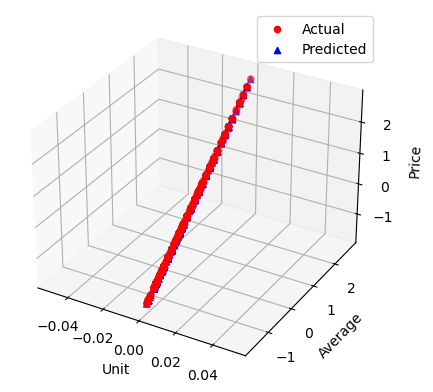

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score




# Function to handle outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df



#load the data set

df=pd.read_csv(r'C:\Users\nh013\Desktop\tomato.csv\Tomato.csv')

#feature selection

df=df[['Date','Unit','Minimum','Maximum','Average','Market']]

# Replace 'Unknown' values with NaN values in 'Unit' column
df['Unit'] = df['Unit'].replace('Unknown', 0)

# fill NaN values in Unit column with '0'
df['Unit'] = df['Unit'].fillna('0')

#identify missing data

print(df.isnull().sum())

#drop rows with missing values

df.dropna(inplace=True)

# fill missing value with mean or median

mean=df.mean()
df.fillna(mean, inplace=True)

#fill missing vlues with mode

mode=df.mode().iloc[0]
df.fillna(mode, inplace=True)

#fill missing values with forward fill

df.fillna(method='ffill', inplace=True)

#fill missing values with backward fill

df.fillna(method='bfill', inplace=True)

# Convert 'Unit' column to numerical format (assuming all values are in kg)
df['Unit'] = pd.to_numeric(df['Unit'].str.replace('Kg', '').str.replace(',', ''))


# Handle outliers
df = handle_outliers(df, 'Average')

# One-hot encode categorical variable 'Market'
df = pd.get_dummies(df, columns=['Market'])


#remove dublicates rows

df.drop_duplicates(inplace=True)

scaler = MinMaxScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])


# Normalize and scale all numerical columns
scaler = StandardScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# Replace 'Unknown' values with NaN values in 'Unit' column
df['Unit'] = df['Unit'].replace('Unknown', 0)

# fill NaN values in Unit column with '0'
df['Unit'] = df['Unit'].fillna('0')

# Calculate rolling mean and standard deviation for 'Average' column
df['Average_rolling_mean'] = df['Average'].rolling(window=30).mean()
df['Average_rolling_std'] = df['Average'].rolling(window=30).std()

# Drop rows with NaN values after calculating rolling mean and std
df.dropna(inplace=True)

# Split data into training and testing sets
X = df[['Unit', 'Average', 'Average_rolling_mean', 'Average_rolling_std']]
y = df['Average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Convert data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

#Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

#Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

#Fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=32)

#Evaluate the model on the testing data
score = model.evaluate(X_test, y_test)
print("Test loss:", score)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: {:.2f}".format(mse))


print(df)

# Create a 3D plot of predicted vs. actual values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['Unit'], X_test['Average'], y_test, c='r', marker='o')
ax.scatter(X_test['Unit'], X_test['Average'], y_pred, c='b', marker='^')
ax.set_xlabel('Unit')
ax.set_ylabel('Average')
ax.set_zlabel('Price')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [5]:
# train model using RNNs 

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense



# Function to handle outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df



#load the data set

df=pd.read_csv(r'C:\Users\nh013\Desktop\tomato.csv\Tomato.csv')

#feature selection

df=df[['Date','Unit','Minimum','Maximum','Average','Market']]

# Replace 'Unknown' values with NaN values in 'Unit' column
df['Unit'] = df['Unit'].replace('Unknown', 0)

# fill NaN values in Unit column with '0'
df['Unit'] = df['Unit'].fillna('0')

#identify missing data

print(df.isnull().sum())

#drop rows with missing values

df.dropna(inplace=True)

# fill missing value with mean or median

mean=df.mean()
df.fillna(mean, inplace=True)

#fill missing vlues with mode

mode=df.mode().iloc[0]
df.fillna(mode, inplace=True)

#fill missing values with forward fill

df.fillna(method='ffill', inplace=True)

#fill missing values with backward fill

df.fillna(method='bfill', inplace=True)

# Convert 'Unit' column to numerical format (assuming all values are in kg)
df['Unit'] = pd.to_numeric(df['Unit'].str.replace('Kg', '').str.replace(',', ''))


# Handle outliers
df = handle_outliers(df, 'Average')

# One-hot encode categorical variable 'Market'
df = pd.get_dummies(df, columns=['Market'])


#remove dublicates rows

df.drop_duplicates(inplace=True)

scaler = MinMaxScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])


# Normalize and scale all numerical columns
scaler = StandardScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# Replace 'Unknown' values with NaN values in 'Unit' column
df['Unit'] = df['Unit'].replace('Unknown', 0)

# fill NaN values in Unit column with '0'
df['Unit'] = df['Unit'].fillna('0')


#using time based featuring
# Convert the datetime column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.weekofyear


# Set the number of time steps to use for prediction
time_steps = 30

# Create input sequences for training
def create_sequences(values, time_steps):
    X = []
    y = []
    for i in range(time_steps, len(values)):
        X.append(values[i-time_steps:i])
        y.append(values[i])
    return np.array(X), np.array(y)

# Create input sequences for training
X, y = create_sequences(df['Average'].values, time_steps)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Define the model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=100, batch_size=32)

# Evaluate the model on the test set
loss = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test)
print('Test loss:', loss)

# Use the model to predict future prices
future_time_steps = 7 # Predict the next 7 days
future_prices = []
last_sequence = X[-1]
for i in range(future_time_steps):
    prediction = model.predict(last_sequence.reshape((1, time_steps, 1)))
    future_prices.append(prediction[0][0])
    last_sequence = np.append(last_sequence[1:], prediction[0])

print('Predicted future prices:', future_prices)


print(df)

Date       0
Unit       0
Minimum    0
Maximum    0
Average    0
Market     0
dtype: int64


C:\Users\nh013\AppData\Local\Temp\ipykernel_3608\448578960.py:49: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean=df.mean()
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\nh013\anaconda3\lib\site-packages\sklear

Epoch 1/100
67/67 [==============================] - 7s 26ms/step - loss: 0.3784
Epoch 2/100
67/67 [==============================] - 2s 29ms/step - loss: 0.2084
Epoch 3/100
67/67 [==============================] - 2s 28ms/step - loss: 0.1522
Epoch 4/100
67/67 [==============================] - 2s 28ms/step - loss: 0.1199
Epoch 5/100
67/67 [==============================] - 2s 27ms/step - loss: 0.1162
Epoch 6/100
67/67 [==============================] - 2s 28ms/step - loss: 0.1151
Epoch 7/100
67/67 [==============================] - 2s 29ms/step - loss: 0.1147
Epoch 8/100
67/67 [==============================] - 2s 29ms/step - loss: 0.1154
Epoch 9/100
67/67 [==============================] - 2s 29ms/step - loss: 0.1125
Epoch 10/100
67/67 [==============================] - 2s 26ms/step - loss: 0.1127
Epoch 11/100
67/67 [==============================] - 2s 27ms/step - loss: 0.1150
Epoch 12/100
67/67 [==============================] - 2s 30ms/step - loss: 0.1146
Epoch 13/100
67/67 [=====